In [1]:
# regular packages
import pandas as pd
from pandas import DataFrame as dframe
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from pytensor import shared

import utils
from utils.algos import pyquap # r::rethinking::quap
from utils.data import data # r::rethinking::data
from utils.analysis import * # precis, cov2cor
from utils.stats import * # r::stats functions (rnorm, dnorm, ...)
from utils.plots import init_dag # function to initialize an empty DAG
utils.init() # init plotting styles and hush warnings
np.random.seed(8964) # seed

# Chapter 4 Geocentric Models

Claudius Ptolemy built some extremely accurate model for planet motions. The model is basically circles on circles on circles. With enough circles, he could accurately predict the location of a celestial body in the sky. But the model is simply wrong, although in some narrow domain of query it provides accurate answers. This modeling strategy is the same as a Fourier series.

## Keywords
Prior predictive simulation, grid approximation, quadratic approximation



## Section 4.1. Why normal distributions are normal

Consider the Galton's board as an example. McElreath gave a random walk example similar to that. Let's simulate that here. Say 1000 people were to do random walks from the left end of the yard to the right end. And it takes 16 steps. At each left-to-right step, each person either goes up or down by a number between -1 and 1 also.

Learning outcomes:
- 4.1.1 - 4.1.3: when normality comes
- 4.1.4: justifications of using normal distributions

### Code 4.1 (random walks)

In [2]:
random_walks = np.hstack([np.zeros((1000, 1)), runif((1000, 16), -1, 1)]).cumsum(1)
df_random_walks = dframe(random_walks).T
df_random_walks.columns = "s" + df_random_walks.columns.astype(str)
df_random_walks["step"] = np.arange(17)
df_random_walks = df_random_walks.melt(id_vars=["step"], value_vars=df_random_walks.columns, value_name="position")

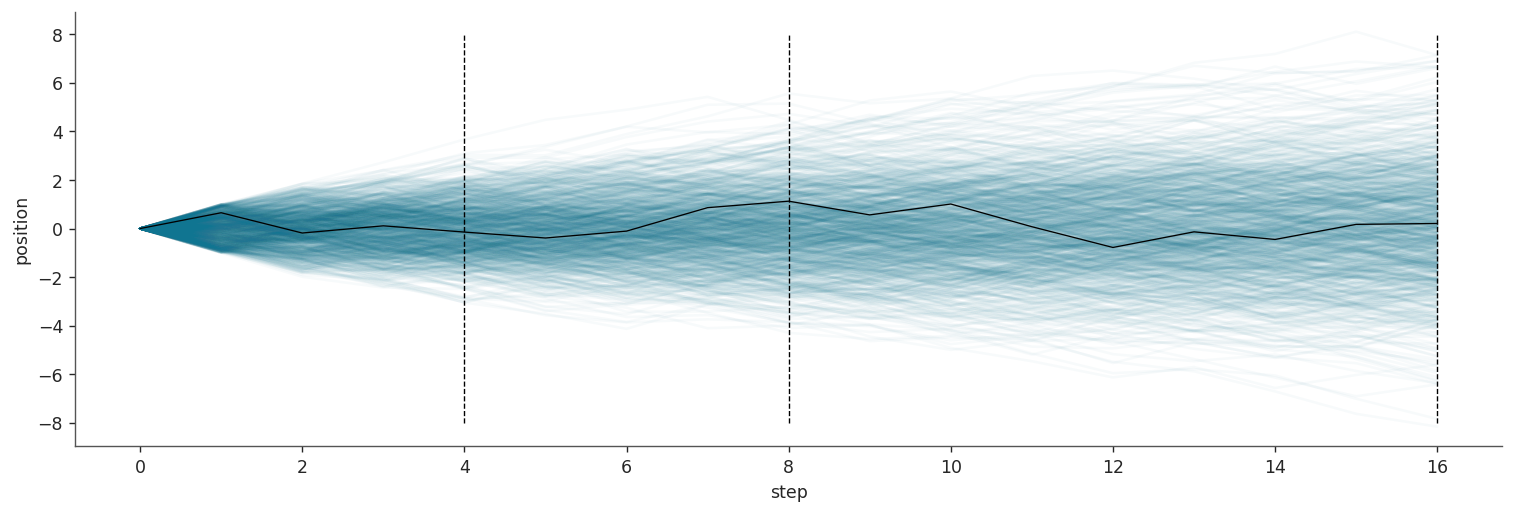

In [3]:
_, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_random_walks, x="step", y="position", units="variable", estimator=None, alpha=0.03, ax=ax)
sns.lineplot(data=df_random_walks[df_random_walks.variable == "s0"], x="step", y="position", ax=ax, color="k", linewidth=0.75)
ax.vlines(x=[4, 8, 16], ymin=-8, ymax=8, color="k", linestyles="dashed", linewidth=0.8);

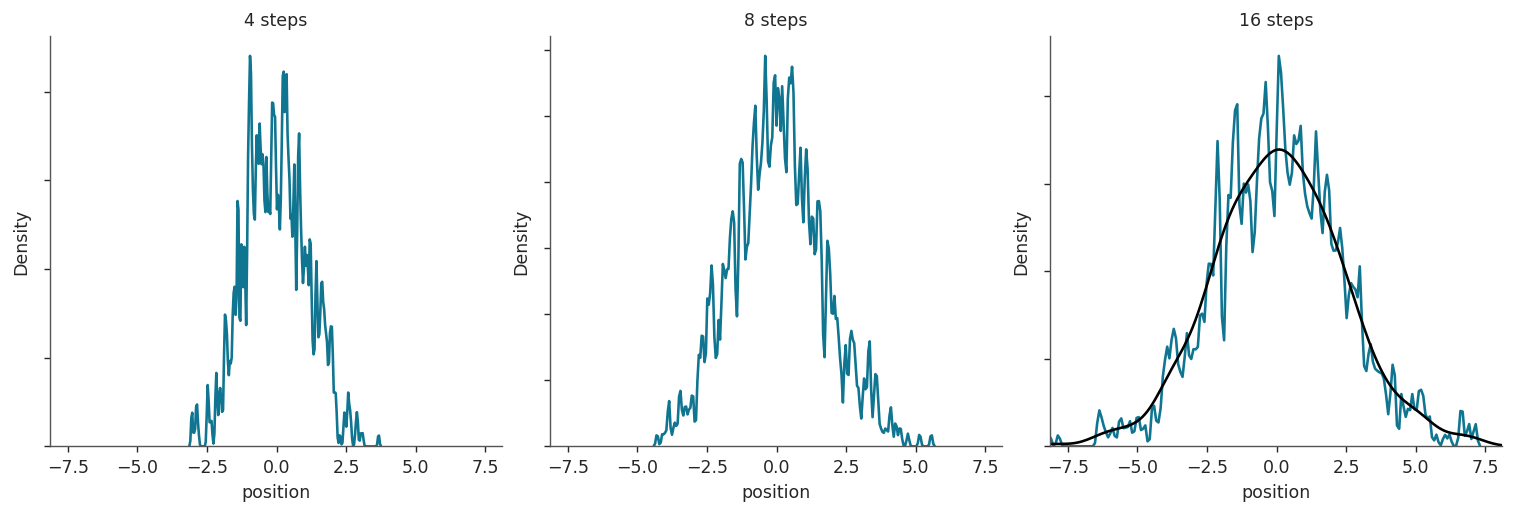

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.kdeplot(random_walks[:, 4], bw_adjust=.1, ax=ax[0])
sns.kdeplot(random_walks[:, 8], bw_adjust=.1, ax=ax[1])
sns.kdeplot(random_walks[:, 16], bw_adjust=.1, ax=ax[2])
sns.kdeplot(random_walks[:, 16], color="k", ax=ax[2])
ax[0].set(title="4 steps")
ax[1].set(title="8 steps")
ax[2].set(title="16 steps")
plt.setp(ax, xlabel="position", xlim=[random_walks.min(), random_walks.max()], yticklabels=[]);

If you add together independent random values from the same distribution, you always get a normal random variable. The underlying distribution of each value can be nearly anything, but the convergence will happen, sometimes slowly. 

### Code 4.2 (normality by multiplication)

Here's another to get a normal distribution.

In [5]:
runif(12, 1, 1.1).cumprod()

array([1.03932484, 1.09925859, 1.18139826, 1.25645023, 1.27039353,
       1.32847531, 1.39215171, 1.46857943, 1.47112896, 1.53952477,
       1.6067144 , 1.61512046])

### Code 4.3 (cont'd)

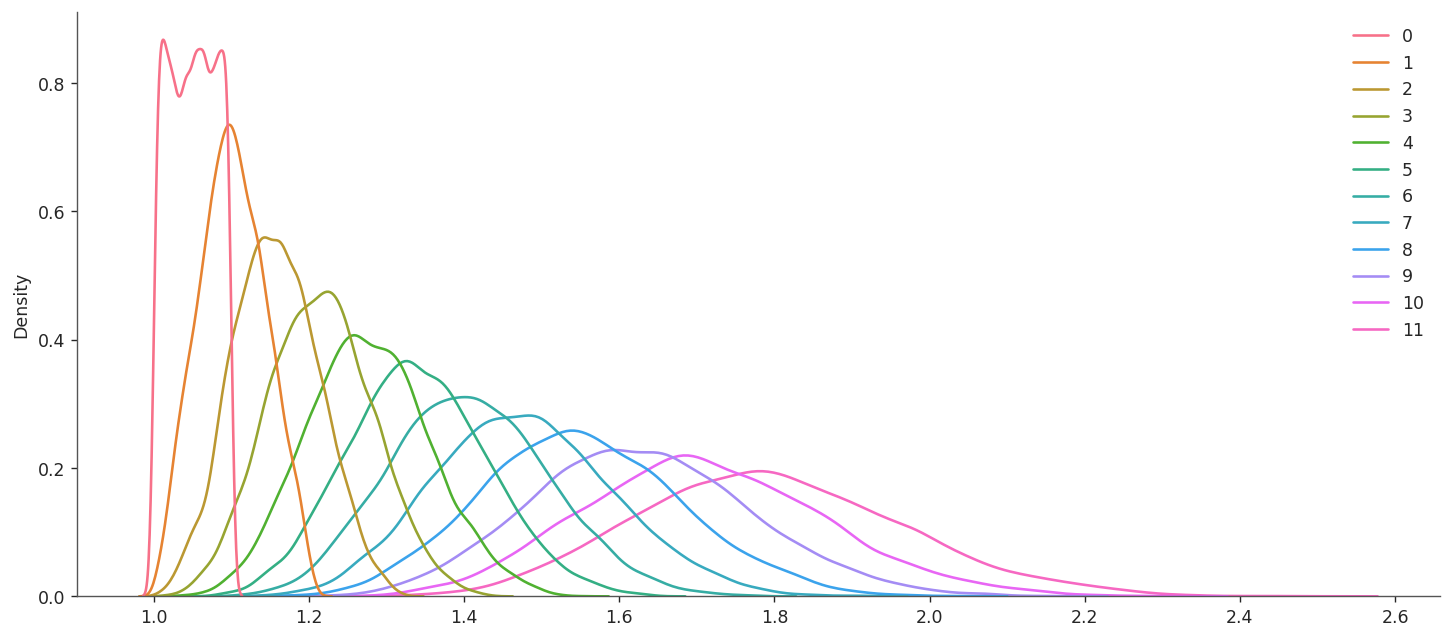

In [6]:
growth = runif((int(1e4), 12), 1, 1.1).cumprod(1)
sns.kdeplot(growth);

### Code 4.4 (cont'd)

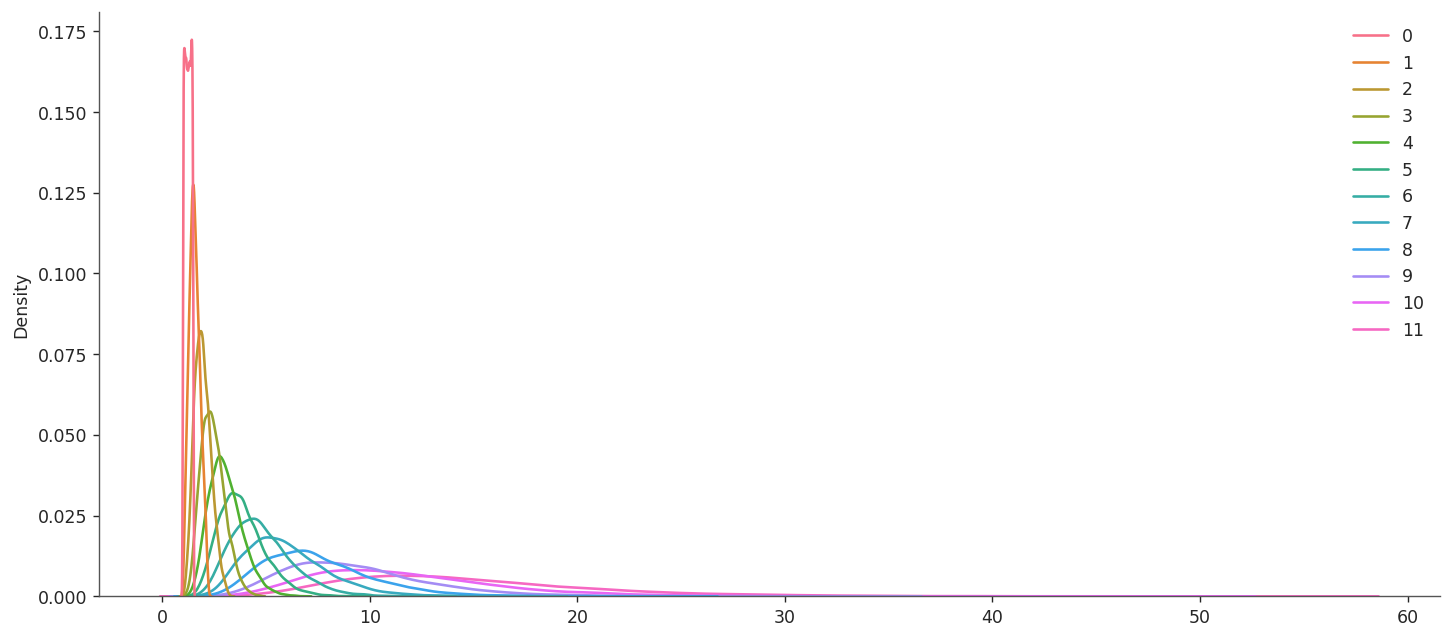

In [7]:
growth = runif((int(1e4), 12), 1, 1.5).cumprod(1)
sns.kdeplot(growth);

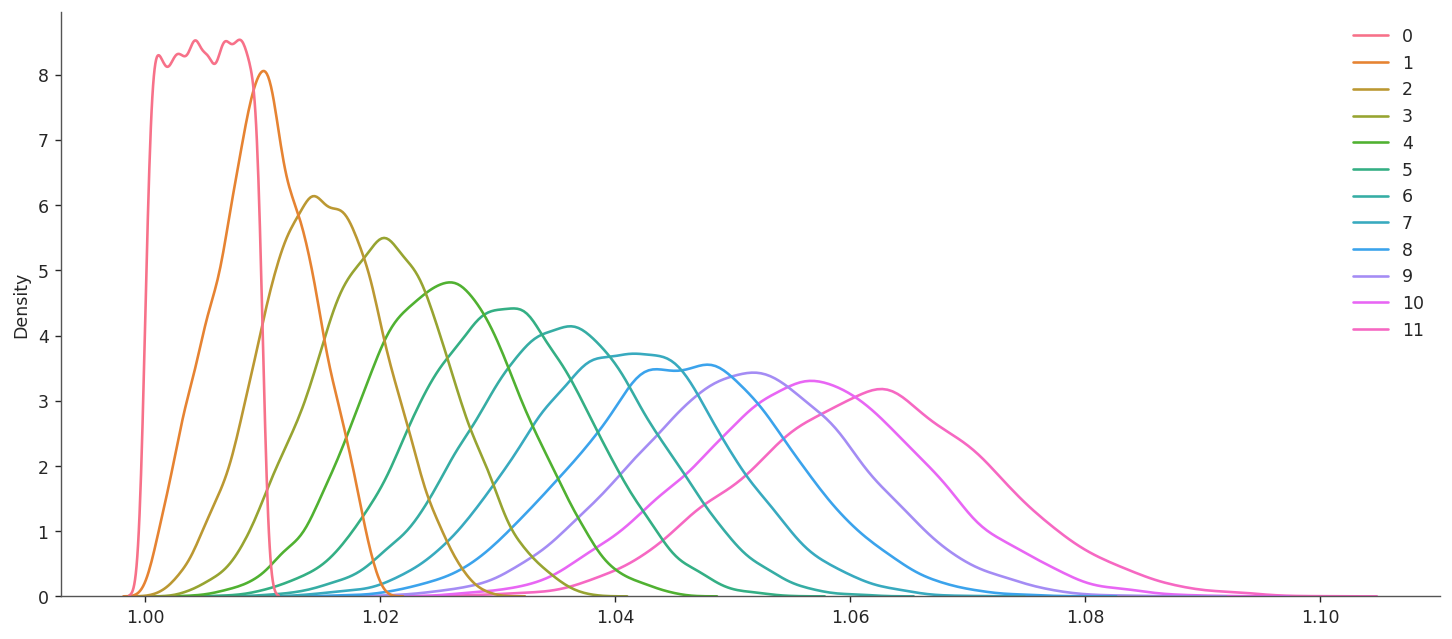

In [8]:
growth = runif((int(1e4), 12), 1, 1.01).cumprod(1)
sns.kdeplot(growth);

The smaller the maximum multiplicative factor can be, the closer the curve is to the bell shape. But wait, large multiplicative factors do tend towards a log normal distribution.

### Code 4.5 (log normal growth)

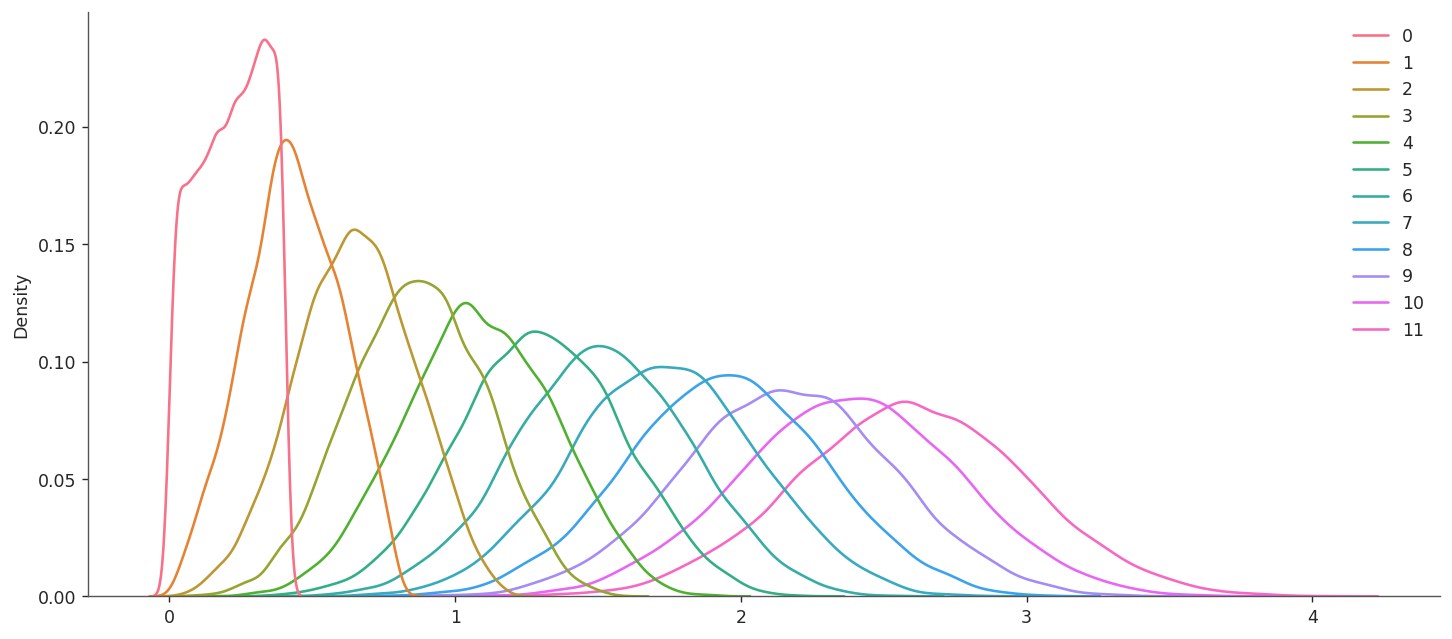

In [9]:
log_big = np.log(runif((int(1e4), 12), 1, 1.5)).cumsum(1)
sns.kdeplot(log_big);

(4.1.4) The justifications for using normal distributions:
1. _Ontological justification_. Whenever there are processes that add together fluctuations, the fluctuations themselves might become less important than their mean and spread. Doing this often prevents us from knowing more about the underlying fluctuations. In a word, Gaussians are just part of the nature.
2. _Epistemological justification_. Gaussian distributions are the most natural expression of our state of ignorance, besides knowing the mean and the variance of the distribution. We will look into this more in later chapters when we talk about information theory and maximun entropy (maxent).

But many natural and unnatural processes have much heavier tails. For example, stock prices can look Gaussian in the short term, but extreme shocks during a long time window make the Gaussian model look foolish. 

An alternative parametrization of Gaussians uses $\tau = 1/\sigma^2$ instead of $\sigma$, called the "precision". 

## Section 4.2. A language for describing models

McElreath tends to refer to data as observed variables, and parameters as unobserved variables. So he makes that point here. Another point is that we should unify our language of defining our statistical models to a form that's similar to how stan or PyMC defines them with code. That way, you do not need to memorize the meaning of crazy terms like _heteroscedasticity_, you can just read the assumptions from your model definition.

### Code 4.6 (grid approximation)
Model:
$$W \sim \text{Binomial}(N, p)$$
$$p \sim \text{Uniform}(0, 1)$$

In [10]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = dbinom(w, n, p_grid)*dunif(p_grid, 0, 1)
posterior /= posterior.sum()

## Section 4.3. Gaussian model of height

We want our Bayesian model to rank all combinations of means and variances by the posterior plausibility.

### Code 4.7 (read Howell1 data)

In [11]:
from utils.data import data
d = data("Howell1")

### Code 4.8 (cont'd)

In [12]:
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


### Code 4.9 (cont'd)

In [13]:
precis(d)

,mean,sd,5.5%,94.5%
height,138.26,27.60,81.11,165.74
weight,35.61,14.72,9.36,54.50
age,29.34,20.75,1.00,66.13
male,0.47,0.50,0.00,1.00


We are just studying the height column for now.

### Code 4.10 (cont'd)

In [14]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11 (cont'd)

Let's now just ignore the correlation between age and height that is often present in non-adults, by simplying filtering out the non-adults data points.

In [15]:
d2 = d[d.age >= 18]

Plot a density plot for the height and see if it looks like a bell curve. The answer is yes. This may be because height is a sum of many small growth factors. But gawking at the data to decide how to model them is usually not a good idea. 

**Rethinking: I.I.D.**. This assumption is hardly true in a physical sense. For the heights in the Howell data, it could be that some of these individuals are from the same families.

But the I.I.D. assumption doesn't need to seem awkward. It is an epistemological assumption, rather than an ontological one. It's only about how our models represent their uncertainty. Jaynes called this the [mind projection fallacy](https://en.wikipedia.org/wiki/Mind_projection_fallacy), when people confuse epistemological claims with ontological claims.

Let's build a model for the adult heights.
$$h_i \sim \text{Normal}(\mu, \sigma)$$
$$\mu \sim \text{Normal}(178, 20)$$
$$\sigma \sim \text{Uniform}(0, 50)$$

Why 178 cm? McElreath is 178 cm tall. And 178 +- 40 encompasses a wide range of plausible human mean heights. Everybody knows something about human heights and thus can set a reasonable vague prior like this. But in many problems, using prior information is more subtle since parameters do not always have physical meaning. Whatever the prior, it's good to plot your priors for confirming what your assumptions are.

### Code 4.12 (plot prior of the mean heights)

See Figure 4.3 top left.

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
x = np.linspace(100, 250, 100)
ax[0, 0].plot(x, dnorm(x, 178, 20))
ax[0, 0].set(title="mu ~ dnorm(178, 20)", xlabel="mu")
plt.close()

### Code 4.13 (plot prior of the height variance)

See Figure 4.4 top right.

How should we pick the upper bound? A standard deviation of 50 cm would imply that 95% of individual heights lie within 100cm of the average height (small world numbers). That's a very large range.

In [17]:
x = np.linspace(-10, 60, 100)
ax[0, 1].plot(x, dunif(x, 0, 50))
ax[0, 1].set(title="sigma ~ dunif(0, 50)", xlabel="sigma");

### Code 4.14 (prior pred of first model)

It also helps to see what our priors imply about the simulated individual heights. (**prior predictive simulation**).

See Figure 4.3 bottom left.

In [18]:
n_samples = int(1e4)
sample_mu = rnorm(n_samples, 178, 20)
sample_sigma = runif(n_samples, 0, 50)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)

plt.setp(ax, yticklabels=[])
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 0])
ax[1, 0].set(title="h ~ dnorm(mu, sigma)", xlabel="height");

### Code 4.15 (prior pred, alt)

See Figure 4.3 bottom right.

Consider a much flatter prior $\mu \sim \text{Normal}(178, 100)$.  Note that there is a significant portion of humans with negative heights, also with heights more than 272 cm (one of the tallest people in history).

These crazy priors are not harmful here because we have 544 rows of data. But for cases where data are not sufficient, we have to use our scientific knowledge to construct sensible priors, then we can use Bayes to proceed.

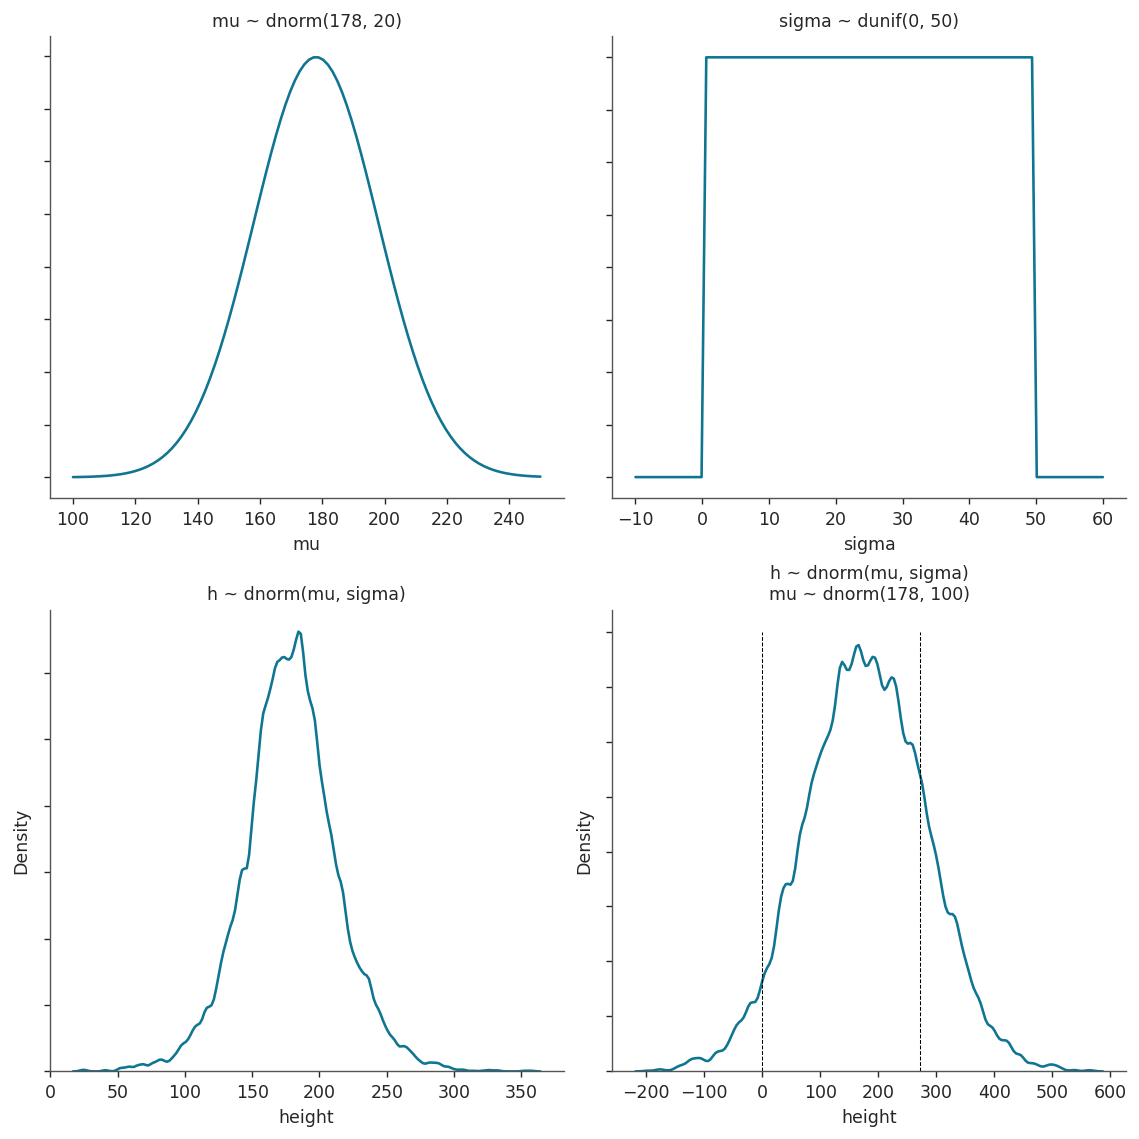

In [19]:
sample_mu = rnorm(n_samples, 178, 100)
prior_h = rnorm(n_samples, sample_mu, sample_sigma)
sns.kdeplot(prior_h, bw_adjust=.4, ax=ax[1, 1])
ax[1, 1].vlines(x=[0, 272], ymin=0, ymax=0.004, linestyles=["dashed"], colors=["k"], linewidth=0.6)
ax[1, 1].set(title="h ~ dnorm(mu, sigma)\nmu ~ dnorm(178, 100)", xlabel="height")
fig

Figure 4.3. Top row: prior distributions for $\mu$ and $\sigma$. Bottom row: prior predictive simulations for height, left with the $\mu$ prior in our model, right with a flatter $\mu$ prior.

### Code 4.16 (grid approx, first model)

Since this is our first model, let's use grid approximation to calculate the posterior.


In [20]:
mus = np.linspace(150, 160, 100)
sigmas = np.linspace(7, 9, 100)
post_LL = dnorm(d2.height, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

### Code 4.17 (grid posterior contour)

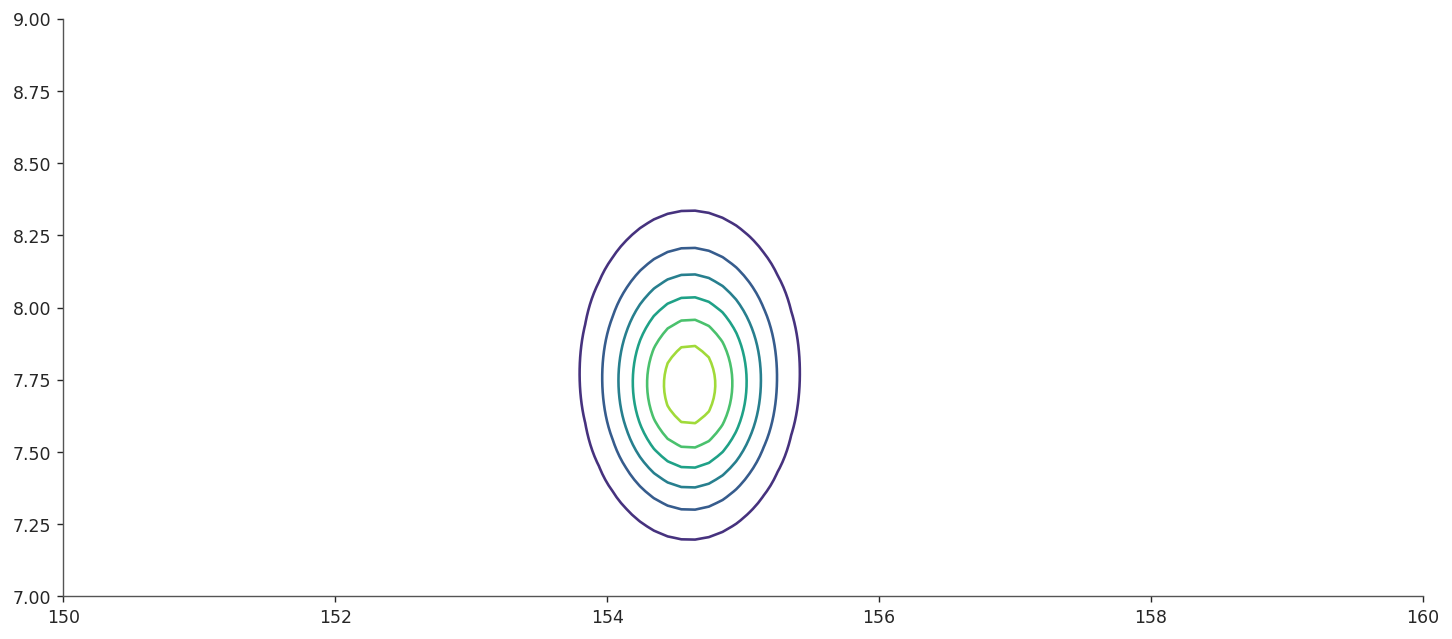

In [21]:
plt.contour(mus, sigmas, post_prob);

### Code 4.18 (2d grid posterior heatmap)

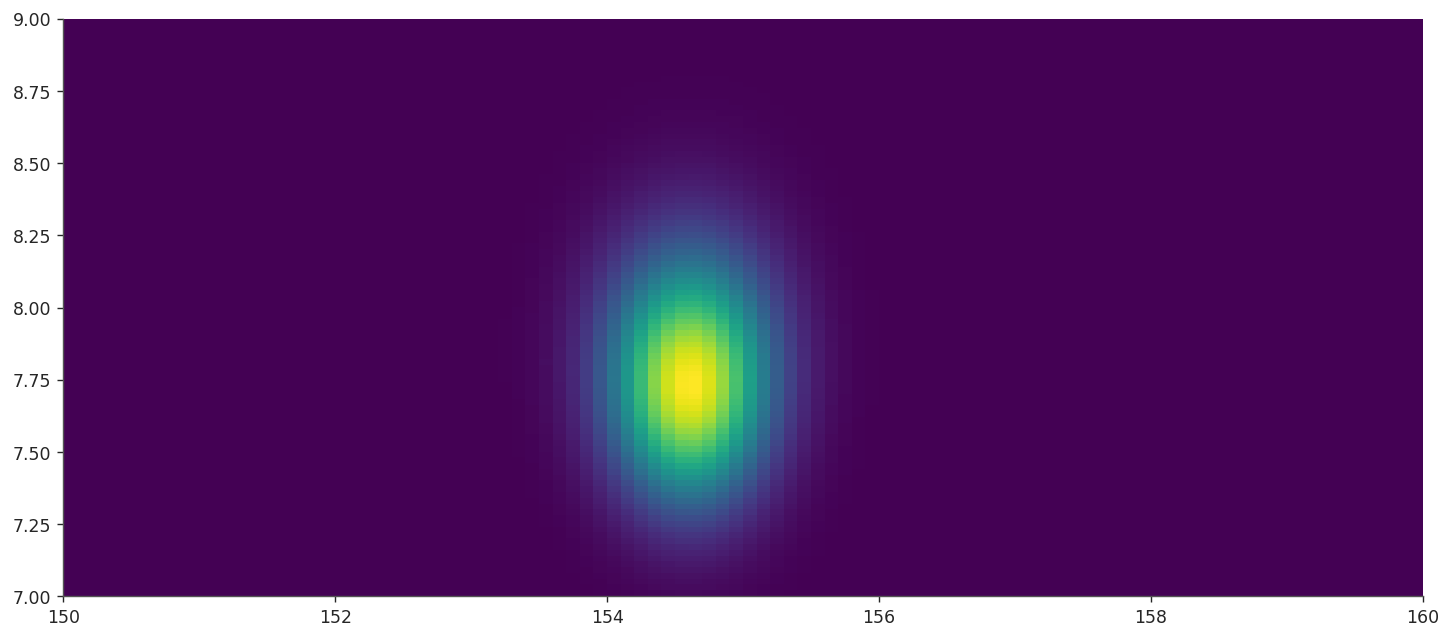

In [22]:
_, ax = plt.subplots()
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

### Code 4.19 (posterior sample from 2d grid)

In [23]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

### Code 4.20 (plot sampled 2d params)

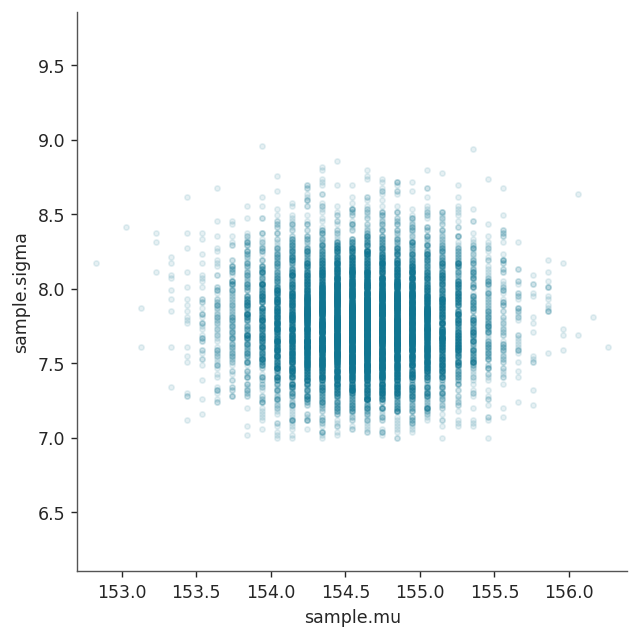

In [24]:
_, ax = plt.subplots(figsize=(5, 5))
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

Figure 4.4. Samples from the posterior distribution for the heights data.

### Code 4.21 (marginal plots)

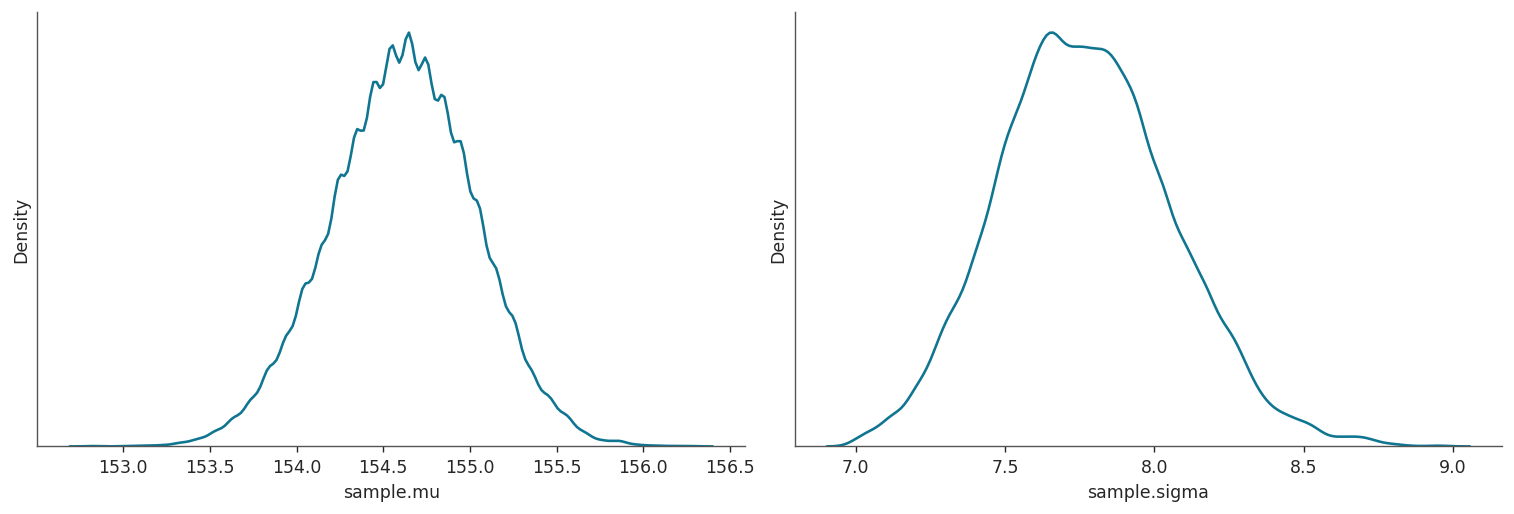

In [25]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(sample_mus, bw_adjust=.7, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(sample_sigmas, bw_adjust=.7)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

### Code 4.22 (plausibility intervals)

In [26]:
az.hdi(sample_mus), az.hdi(sample_sigmas)

(array([153.83838384, 155.15151515]), array([7.24242424, 8.17171717]))

We are about to forget the grid approximation and get to quadratic approximation. Often if you do quadratic approximation for your normal posterior, the $\sigma$ tends to have a long right tail. An intuitive explanation is, the bigger the variance, the bigger the uncertainty.

It is deemed worth repeating the analysis of the height data above, but now with only a fraction of the data, to demonstrate the point discussed above.

### Code 4.23 (subset of Howell1)

In [27]:
d3 = choice(d2.height, 20)

### Code 4.24 (grid approx on subset)

In [28]:
mus = np.linspace(150, 170, 200)
sigmas = np.linspace(4, 20, 200)
post_LL = dnorm(d3, mus.reshape(1, -1, 1), sigmas.reshape(-1, 1, 1), log=True).sum(-1)
post_prod = post_LL + dnorm(mus.reshape(1, -1), 178, 20, True) \
                    + dunif(sigmas.reshape(-1, 1), 0, 50, True)
post_prob = np.exp(post_prod - post_prod.max())

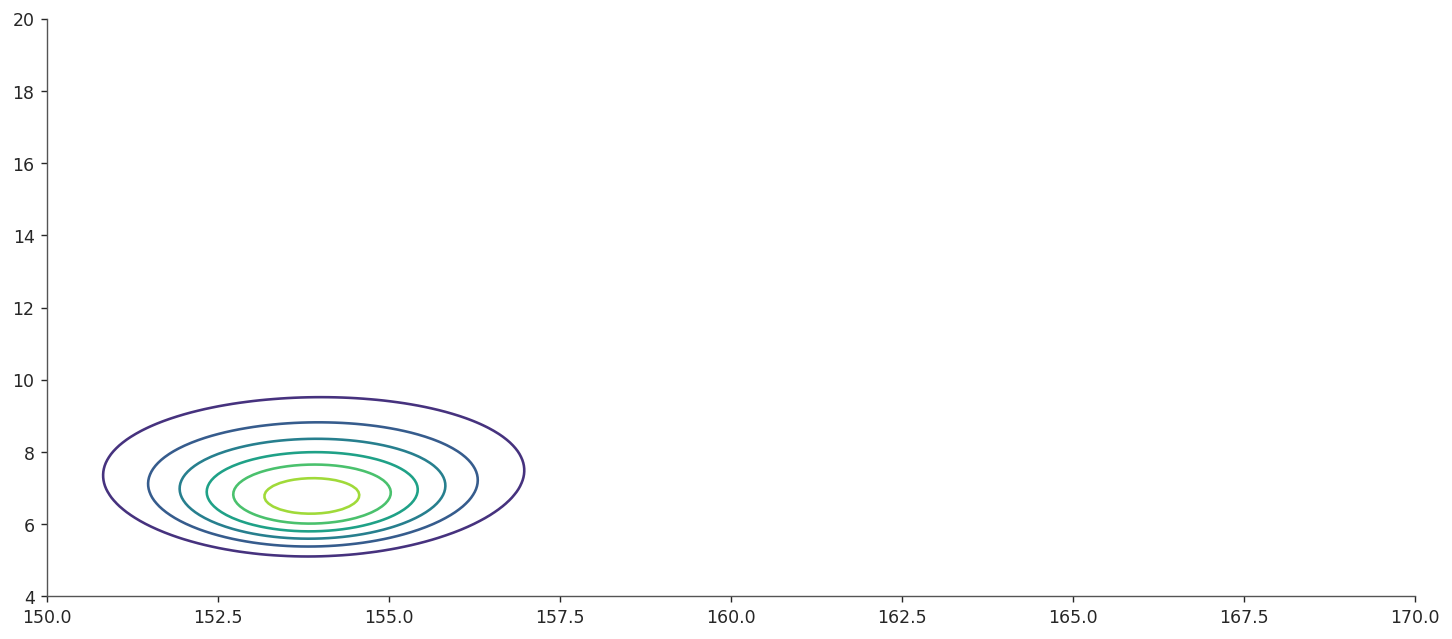

In [29]:
plt.contour(mus, sigmas, post_prob);

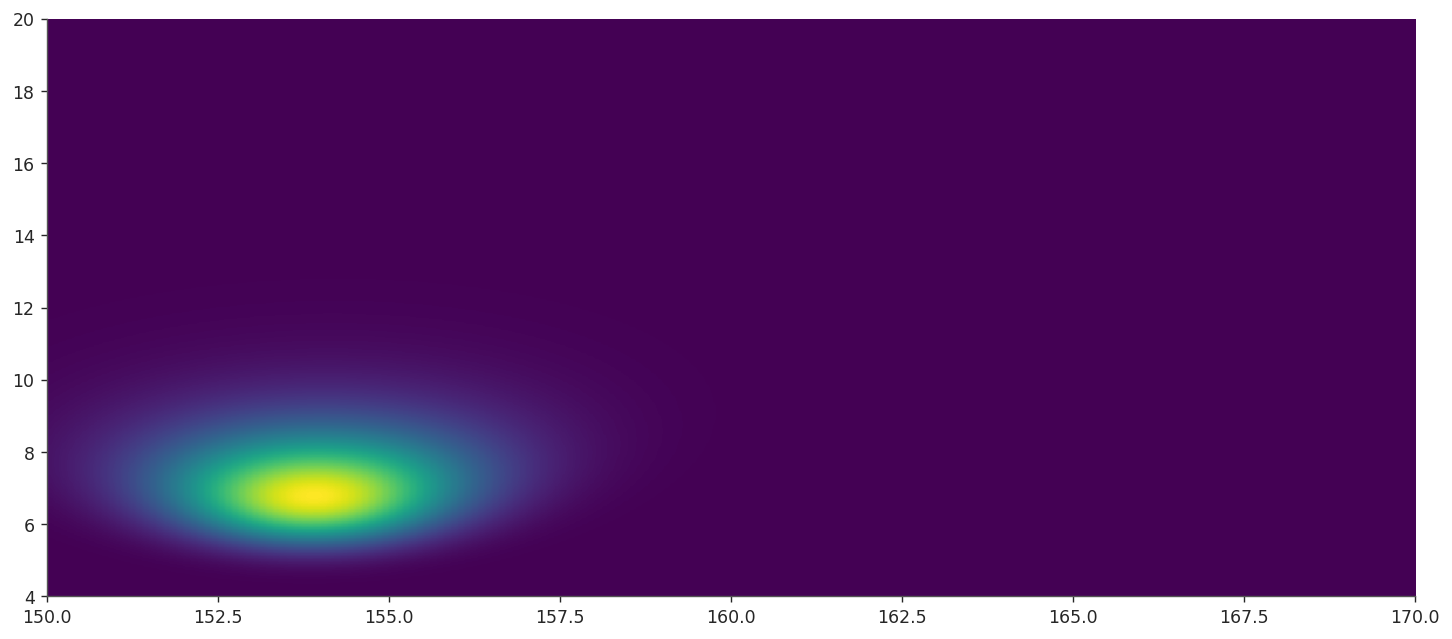

In [30]:
_, ax = plt.subplots()
ax.imshow(post_prob, origin="lower", aspect="auto", 
          extent=[mus.min(), mus.max(), sigmas.min(), sigmas.max()])
ax.grid(False);

In [31]:
mu_copies, sigma_copies = np.meshgrid(mus, sigmas)
long_mus, long_sigmas, long_post_prob = mu_copies.flatten(), sigma_copies.flatten(), post_prob.flatten()

sample_rows = choice(
    np.arange(len(long_mus)), size=10000, replace=True, p=long_post_prob/long_post_prob.sum()
)

sample_mus = long_mus[sample_rows]
sample_sigmas = long_sigmas[sample_rows]

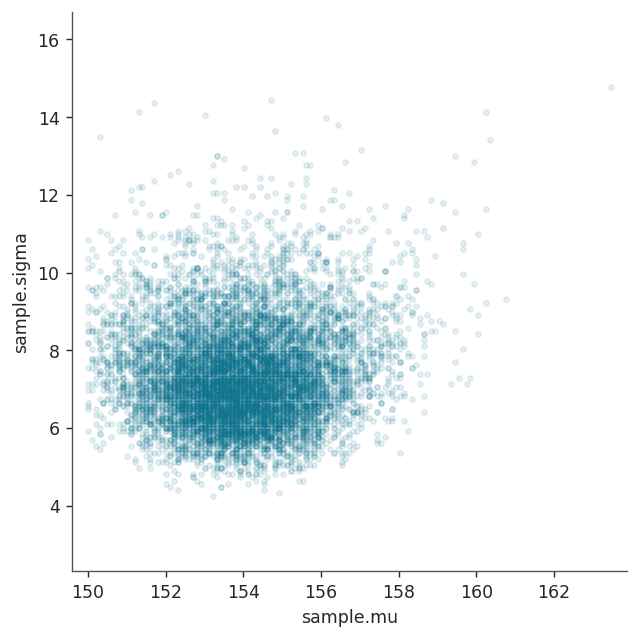

In [32]:
_, ax = plt.subplots(figsize=(5, 5))
ax.axis("equal")
ax.plot(sample_mus, sample_sigmas, ".", alpha=0.1)
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

From the plots, we can see that sigma's posterior has a long right tail. Also see the posterior plot below.

### Code 4.25 (sigma posterior plot)

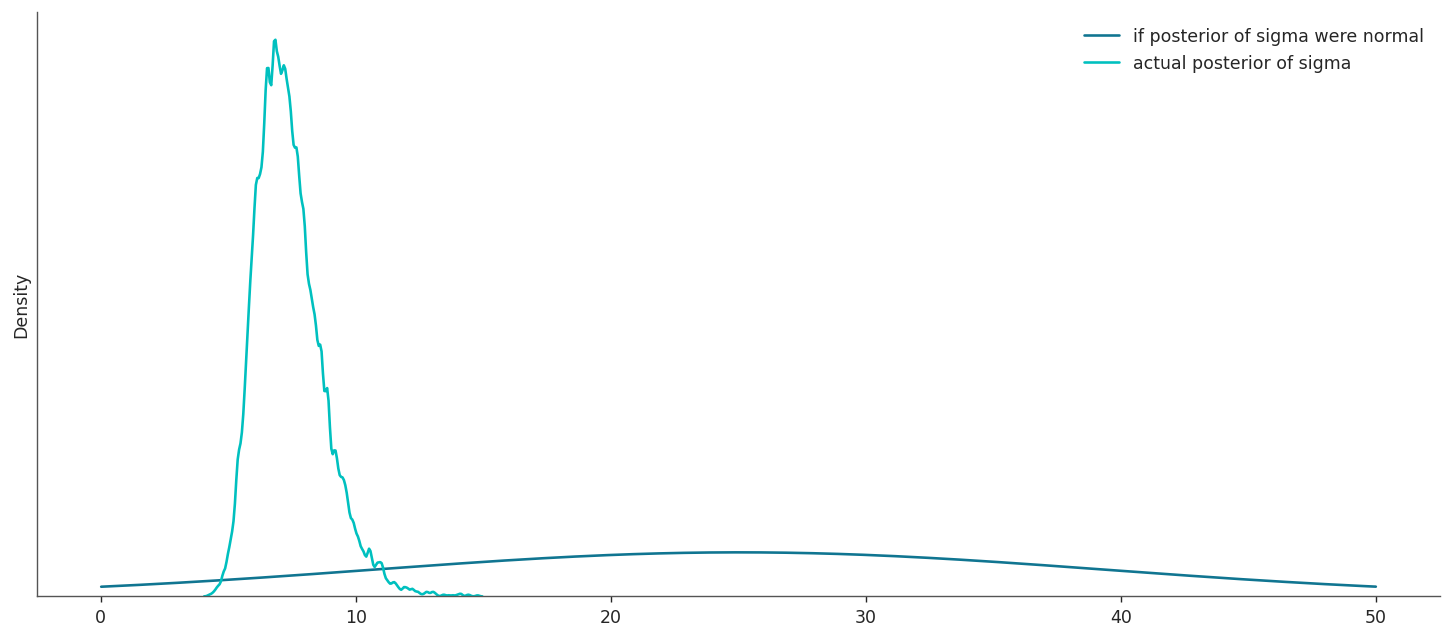

In [33]:
sigs = np.linspace(sample_sigma.min(), sample_sigma.max(), 200)
plt.plot(sigs, dnorm(sigs, sample_sigma.mean(), sample_sigma.std()), label="if posterior of sigma were normal")
sns.kdeplot(sample_sigmas, bw_adjust=.3, label="actual posterior of sigma")
plt.legend()
plt.yticks([]);

4.3.5 Quadratic approximation. This type of optimizer finds the peak/MAP/mode of the posterior, and also estimates the quadratic curvature at the MAP to produce an approximated posterior. **This is very similar to what many non-Bayesian procedures do, just without the priors.**

Consider a unimodal posterior density of $x$, $f(x)$, whose maximum is $x_0$. We can just approximate this density by doing a 2nd-order Taylor approximation around the posterior mode (given that we located the mode) on the log scale. The first order term becomes zero because the first derivative is evaluated at the mode, then we are left with a quadratic term to be then exponentiated (sounds quite familiar eh?), and a constant factor.

Laplace/normal/quadratic approximation replaces the problem of integration with the problem of maximization. Maximizing something often comes faster with a lot of off-the-shelf optimizers.

### Code 4.26 (reload Howell1 data)

In [35]:
d = data("Howell1")
d2 = d[d.age >= 18]

### Code 4.27 - 4.28 (quadratic approx with `autograd` and `scipy`)

In [36]:
mu_mu, mu_sigma = 178, 20
sigma_l, sigma_u = 0, 50

def height_model_obj(params, data):
    mu, sigma = params[0], params[1]
    return -dnorm_(data, loc=mu, scale=sigma, log=True).sum() \
         - dnorm_(mu, loc=mu_mu, scale=mu_sigma, log=True) \
         - dunif_(sigma, lower=sigma_l, upper=sigma_u, log=True)

m4_1 = pyquap()
m4_1.define_objective(height_model_obj)
init_mu, init_sigma = rnorm(1, mu_mu, mu_sigma), runif(1, sigma_l, sigma_u)
m4_1.set_init_params(np.array([init_mu, init_sigma]))
m4_1.fit(data=d2.height.values)

Optimization terminated successfully.


### Code 4.29 (sample posterior params)

In [37]:
samples = m4_1.sample(4000)
precis(dframe({"mu": samples[:, 0], "sigma": samples[:, 1]}))

,mean,sd,5.5%,94.5%
mu,154.61,0.42,153.94,155.28
sigma,7.74,0.30,7.26,8.21


If comparing the above summary table with that from a grid approximation (summarize grid approximated samples from previous code this section), you will find they are quite similar. This is expected if the true posterior is approximately Gaussian.

**Overthinking: initial parameter values for finding the posterior mode.** In Code 4.27-4.28, the initial parameter values fed to the optimizer are sampled from the prior. But it's also possible to specify initial values with information from the data.

### Code 4.30 (quadratic approx, informed initial values)

In [38]:
m4_1.set_init_params(np.array([d2.height.mean(), d2.height.std()]))
m4_1.fit(data=d2.height.values)

Optimization terminated successfully.


### Code 4.31 (concentrated mu prior)

In [39]:
mu_mu, mu_sigma = 178, .1
sigma_l, sigma_u = 0, 50

m4_2 = pyquap()
m4_2.define_objective(height_model_obj)
init_mu, init_sigma = rnorm(1, mu_mu, mu_sigma), runif(1, sigma_l, sigma_u)
m4_2.set_init_params(np.array([init_mu, init_sigma]))
m4_2.fit(data=d2.height.values)
samples = m4_2.sample(4000)

precis(dframe({"mu": samples[:, 0], "sigma": samples[:, 1]}))

Optimization terminated successfully.


,mean,sd,5.5%,94.5%
mu,177.86,0.10,177.71,178.03
sigma,24.53,0.93,23.05,26.02


Notice that the posterior $\mu$ mode has hardly moved off the prior. But also notice that the $\sigma$ posterior mean has changed a lot from `m4_1`, even if we didn't modify the prior of $\sigma$. 

Once the golem is certain that `mu` is near 178 regardless of what the data says, then the golem needs to change where `sigma` lies to condition on that asserted belief, to get a good fit on the data. 

### Code 4.32 (get covariance matrix)

In [40]:
m4_1.model.cov

array([[1.69784910e-01, 2.68394363e-05],
       [2.68394363e-05, 8.52032891e-02]])

### Code 4.33 (covar and corr matrices)

In [41]:
print(np.diag(m4_1.model.cov))
print(cov2cor(m4_1.model.cov))

[0.16978491 0.08520329]
[[1.0000000e+00 2.2314937e-04]
 [2.2314937e-04 1.0000000e+00]]


The near zero correlation between posterior $\mu$ and $\sigma$ means that learning one of the two does not tell anything about the second.

### Code 4.34 (sample posteriors)

In [42]:
post = m4_1.sample(int(1e4))
post[:6]

array([[154.86086397,   7.93608714],
       [154.24235169,   7.61975198],
       [154.4946571 ,   7.96983558],
       [154.8601366 ,   8.26198587],
       [154.67621113,   7.47068405],
       [155.10402351,   7.95440454]])

### Code 4.35 (summarize sampled posteriors)

In [43]:
samples = dframe({"mu": post[:, 0], "sigma": post[:, 1]})
precis(samples)

,mean,sd,5.5%,94.5%
mu,154.61,0.42,153.95,155.28
sigma,7.73,0.29,7.26,8.19


Density plots of the posterior samples, generally similar to those from grid approximation (Code 4.21).

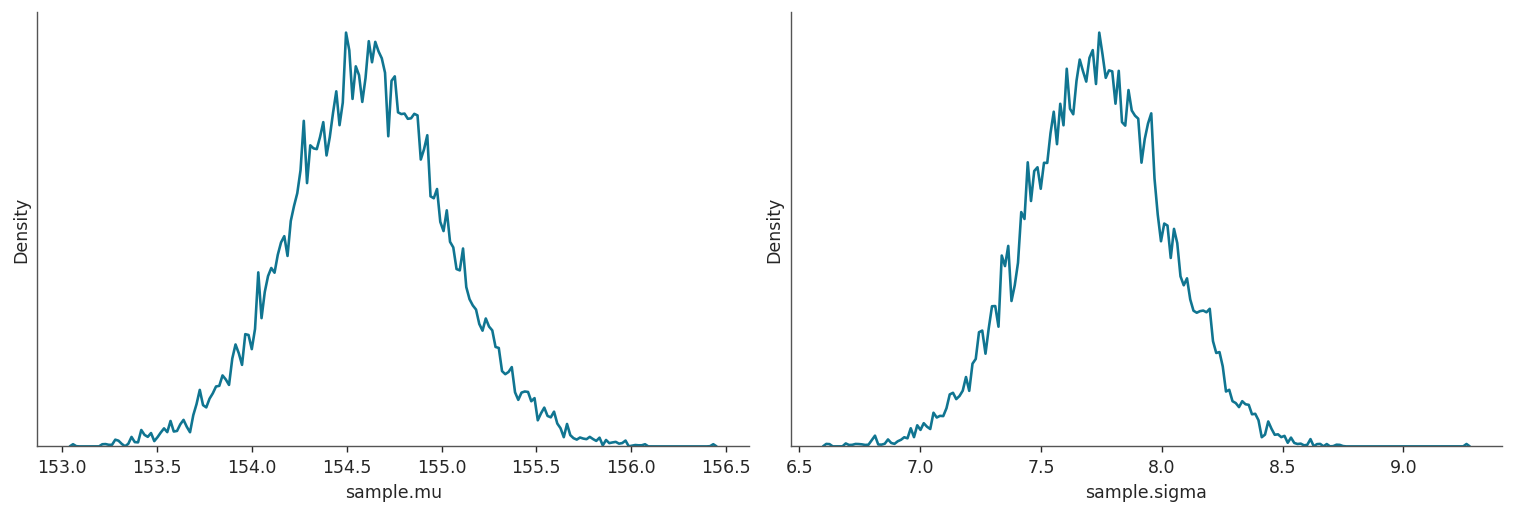

In [44]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(samples.mu, bw_adjust=.1, ax=ax[0])
ax[0].set(xlabel="sample.mu")
sns.kdeplot(samples.sigma, bw_adjust=.1)
ax[1].set(xlabel="sample.sigma")
plt.setp(ax, yticks=[]);

**Overthinking: Under the hood with multivariate sampling.** This is actually quite straightforward. I just called `scipy.stats.multivariate_normal.rvs` with learned parameters' MAPs and covariances. Check the source in `../utils/algos.py`.

### Code 4.36 (sampling mvnorm under the hood)

In [45]:
from scipy.stats import multivariate_normal as mvnorm
post = mvnorm.rvs(size=int(1e4), mean=m4_1.model.mean, cov=m4_1.model.cov)

---

In [13]:
with pm.Model() as height_model:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with height_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [15]:
precis(trace)

,mean,sd,5.5%,94.5%
mu,154.61,0.42,153.93,155.26
sigma,7.76,0.29,7.32,8.23


In [7]:
az.summary(trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.612,0.410,153.919,155.220,0.007,0.005,3617.0,2790.0,1.0
sigma,7.773,0.298,7.293,8.228,0.005,0.004,3629.0,2831.0,1.0


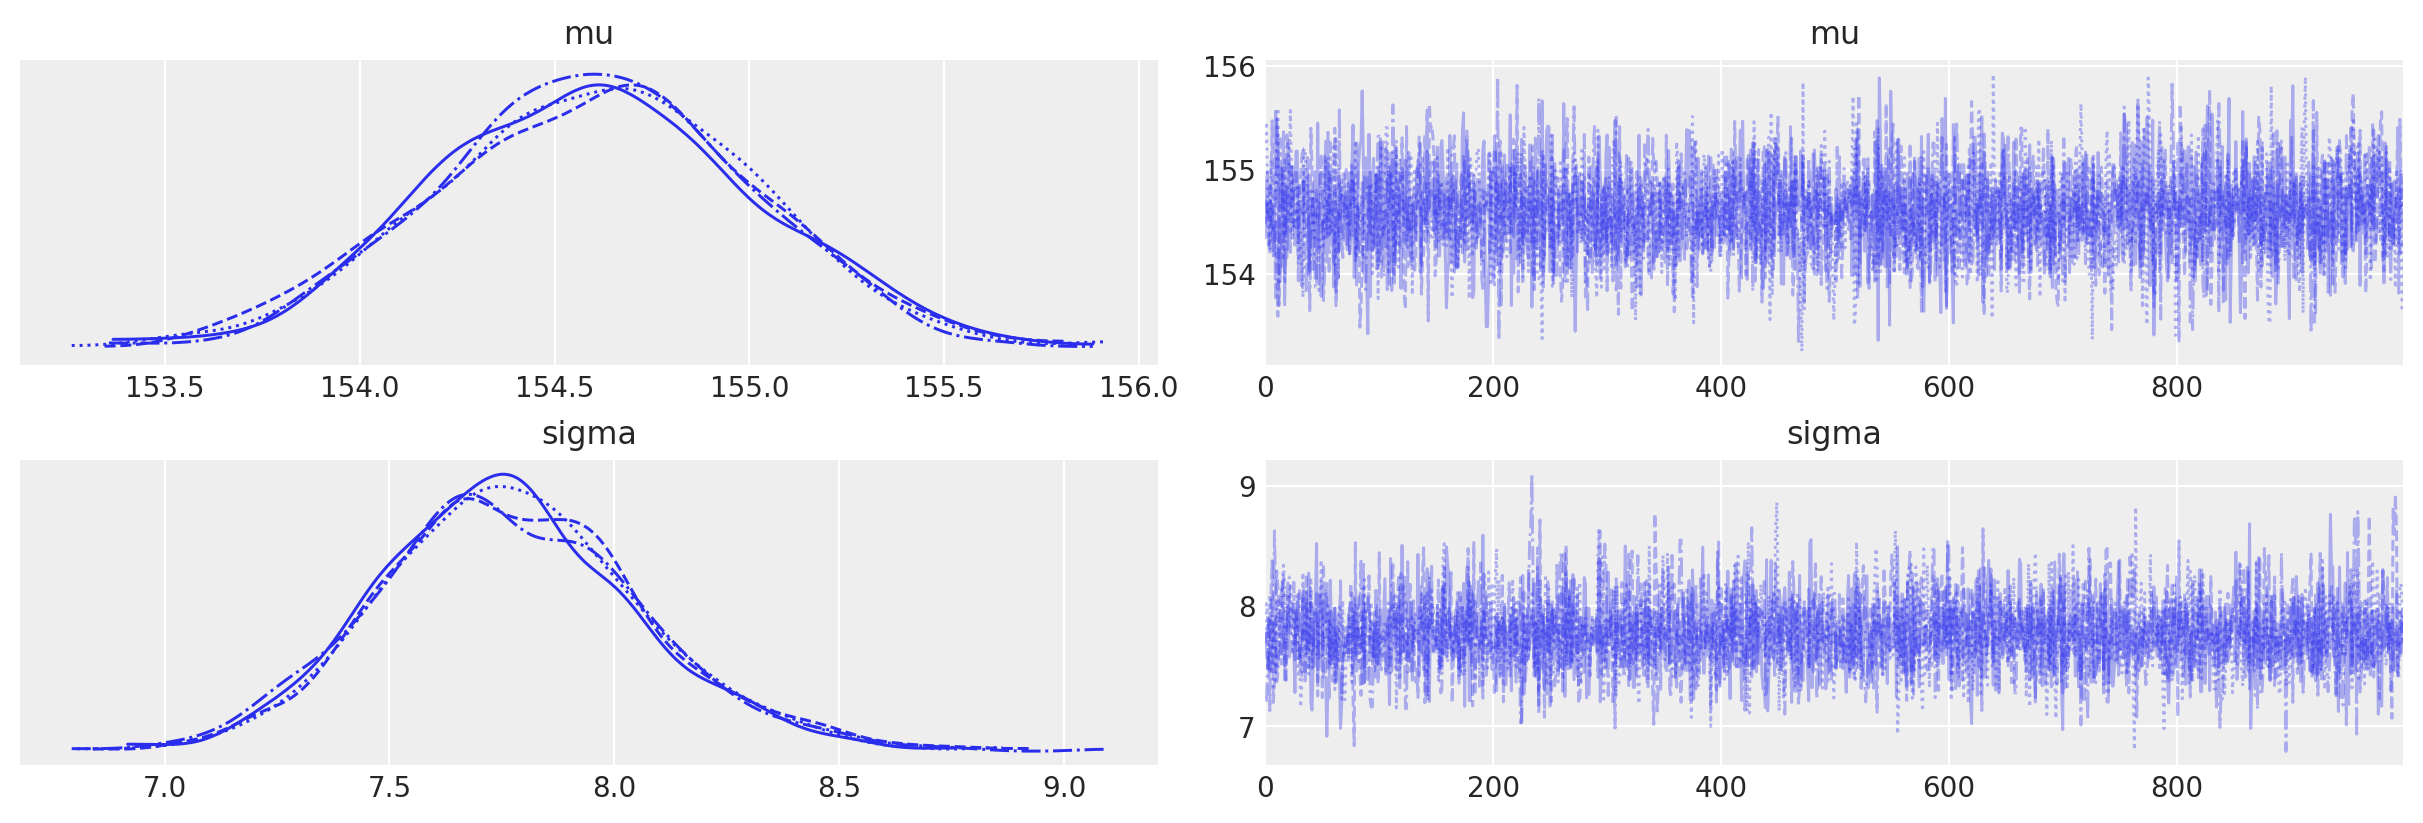

In [30]:
az.plot_trace(trace);

In [32]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

/tmp/ipykernel_1425/3363333656.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
/tmp/ipykernel_1425/3363333656.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [33]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    
with m4_2:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [34]:
trace_df = az.extract_dataset(trace).to_dataframe()
trace_df.cov()

/tmp/ipykernel_1425/1507440975.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  trace_df = az.extract_dataset(trace).to_dataframe()


,mu,sigma,chain,draw
mu,0.009864,0.007757,0.002845,-0.544664
sigma,0.007757,0.922159,0.027879,-7.137681
chain,0.002845,0.027879,1.250313,0.000000
draw,-0.544664,-7.137681,0.000000,83354.088522


In [39]:
trace_df.sigma[0]

draw
0      25.027192
1      24.839433
2      25.398160
3      23.210878
4      24.642703
         ...    
995    24.269006
996    24.817535
997    24.515952
998    25.093714
999    24.880626
Name: sigma, Length: 1000, dtype: float64

In [8]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = a + b*(d2.weight - xbar)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
az.summary(trace_4_3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,154.597,0.269,154.175,155.035,0.004,0.003,5689.0,3032.0,1.0
b,0.903,0.044,0.835,0.973,0.001,0.000,6258.0,3187.0,1.0
sigma,5.102,0.195,4.808,5.422,0.003,0.002,5418.0,3168.0,1.0


In [17]:
trace_df = az.extract(trace_4_3).to_dataframe()
trace_df[["a", "b", "sigma"]].cov()

,a,b,sigma
a,0.074389,0.000115,0.000728
b,0.000115,0.001857,-0.000172
sigma,0.000728,-0.000172,0.037195


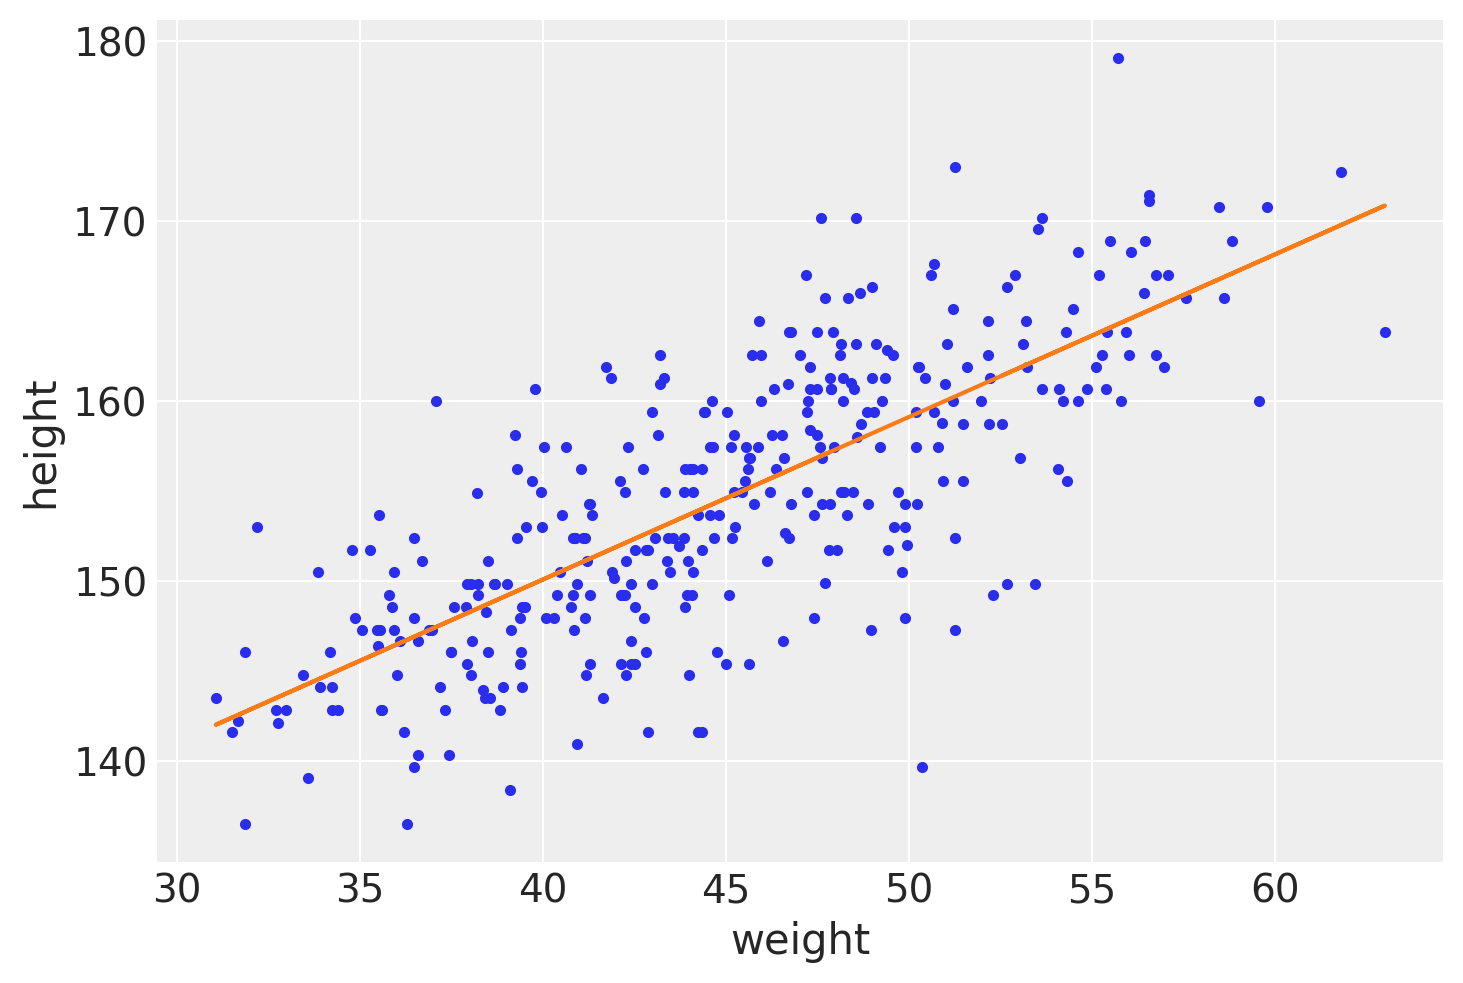

In [20]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(
    d2.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar),
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [57]:
n = 175
dn = d2.iloc[:n, :]
xbar = dn.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + b*(dn.weight - xbar))
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dn.height)
    trace_4_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


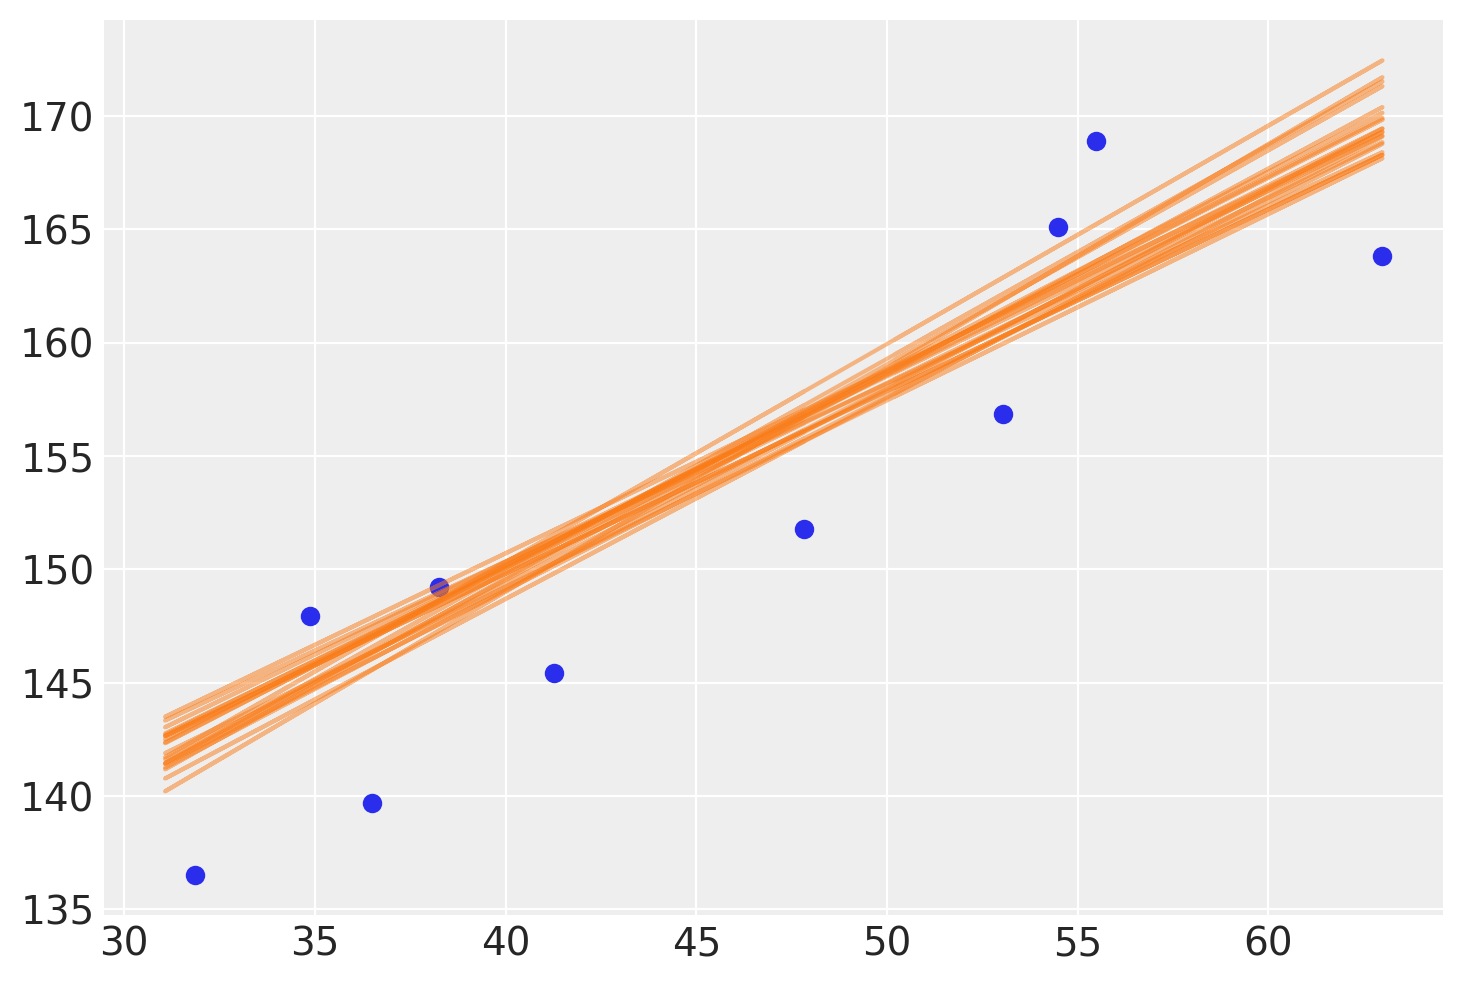

In [59]:
plt.plot(dn.weight[:10], dn.height[:10], "C0o")

trace_df = az.extract(trace_4_3)
n_samples = trace_df.sizes["sample"]
height_rng = np.random.default_rng(2971)
idxs = height_rng.integers(n_samples, size=20)

for idx in idxs:
    plt.plot(
        dn.weight, trace_df["mu"][:, idx],
        "C1-",
        alpha=0.5,
    )

In [54]:
trace_df = az.extract(trace_4_3) # back to full data model
mu_at_50 = trace_df["a"] + trace_df["b"]*(50 - d2.weight.mean())

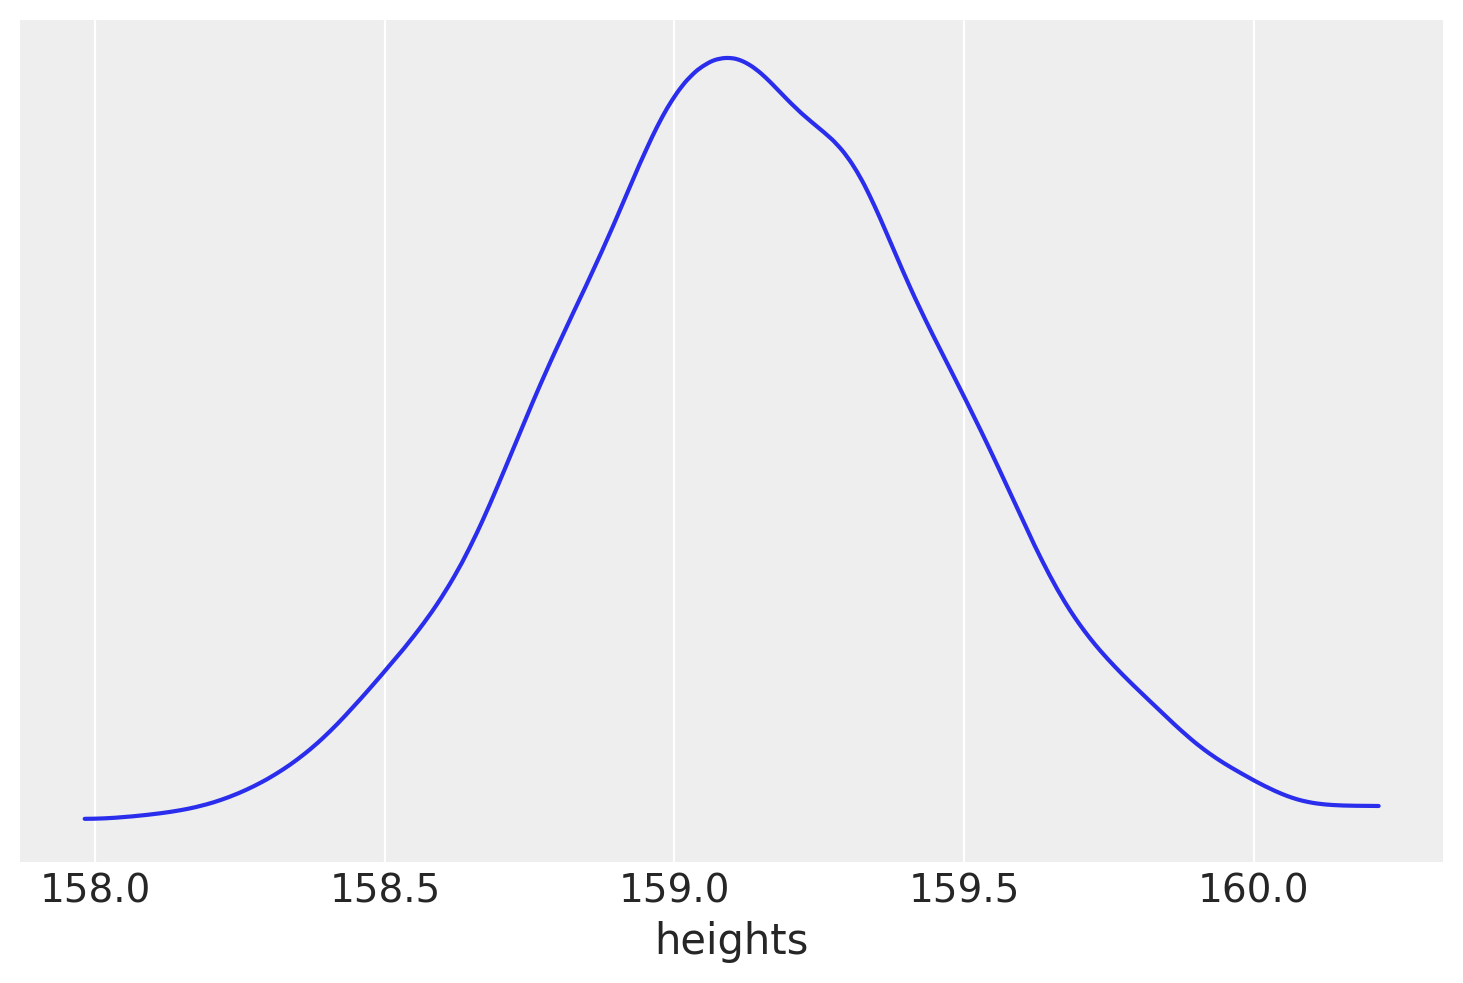

In [56]:
az.plot_kde(mu_at_50.values)
plt.xlabel("heights")
plt.yticks([]);

In [125]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
nb_samples = trace_df.sizes["sample"]
trace_4_3_thinned = trace_df#.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

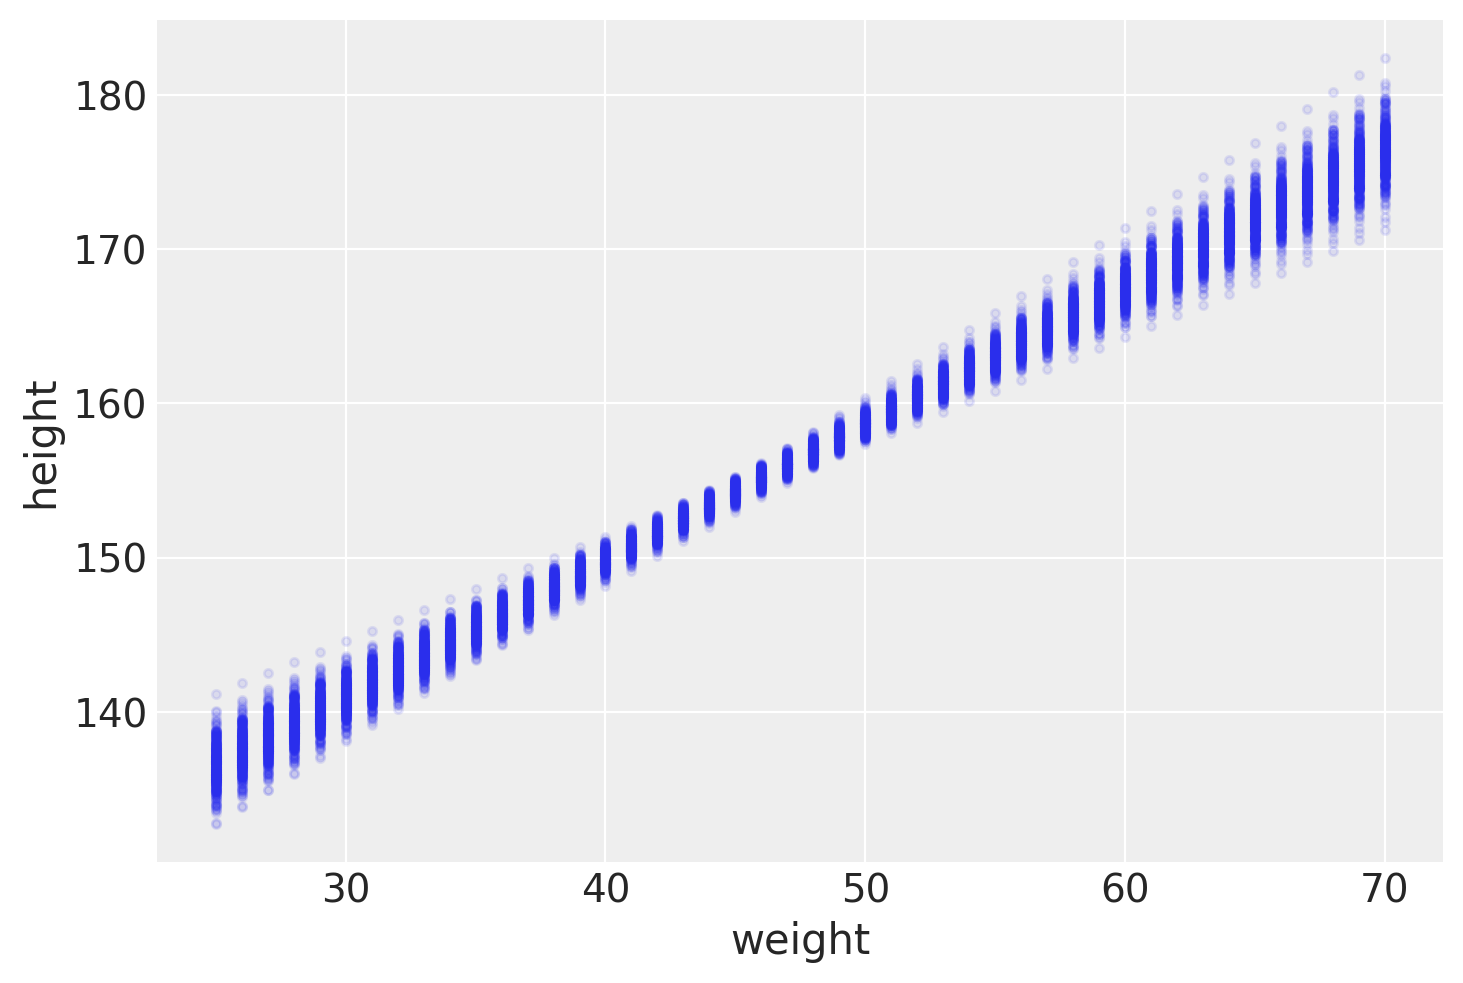

In [61]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

In [62]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

/tmp/ipykernel_35/2684262116.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


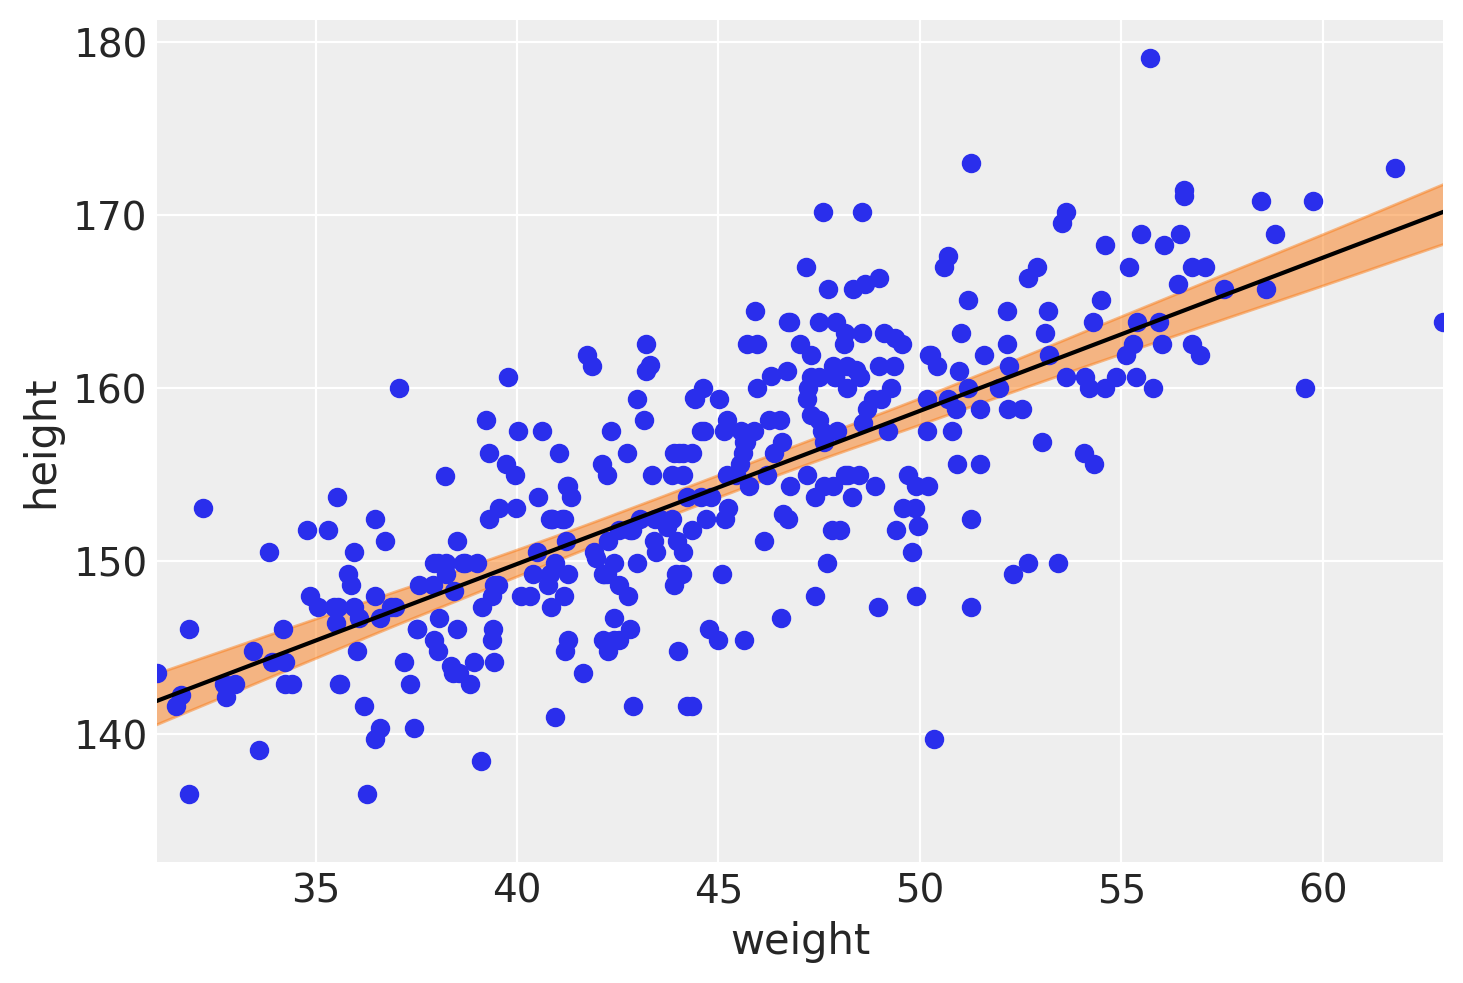

In [69]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [74]:
trace_4_3

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [122]:
thinned_idata = trace_4_3.sel(draw=slice(None, None, 100))
#thinned_idata = trace_4_3
with m4_3:
    height_pred = pm.sample_posterior_predictive(thinned_idata)

Sampling: [height]


In [123]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"])

/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


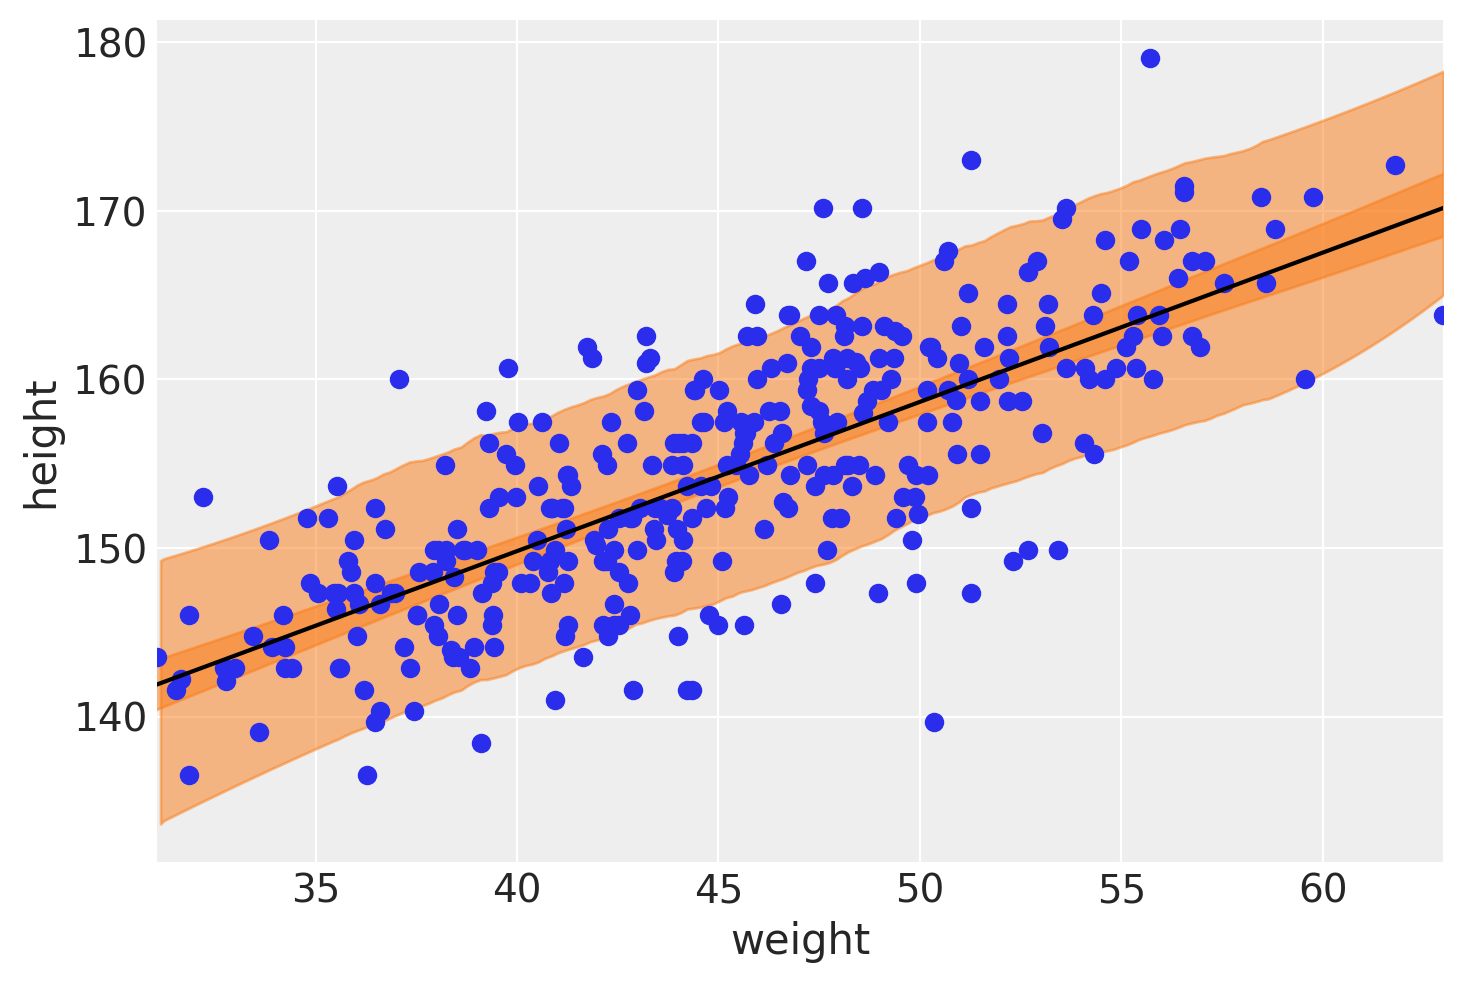

In [126]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

In [128]:
data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

In [35]:
%reload_ext watermark
%watermark -v -iv -p scipy,daft,pytensor -u -n -t

Last updated: Wed Apr 12 2023 22:14:09

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

scipy   : 1.10.1
daft    : 0.1.2
pytensor: 2.10.1

xarray    : 2023.3.0
pymc      : 5.2.0
seaborn   : 0.12.2
arviz     : 0.15.1
autograd  : 1.5
pandas    : 1.5.3
matplotlib: 3.7.1

